## Test fonction run exp

### 1. Imports

In [1]:
import torch
import math

import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import stat_reliability_measure.dev.torch_utils as t_u

from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from stat_reliability_measure.config import Exp2Config
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_config as smc_config

import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.hmls.hmls_pyt as hmls_pyt
import stat_reliability_measure.dev.hmls.hmls_config as hmls_config

import stat_reliability_measure.dev.torch_arch as t_a
from stat_reliability_measure.dev.utils import range_vars,simple_vars
import pandas as pd
import numpy as np
import os 
from stat_reliability_measure.home import ROOT_DIR as rd

### 2. Model & Data load

In [3]:
reload(config_)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = t_a.dnn2()
model.load_state_dict(torch.load('./model_dnn2_release.pt'))
model.to(device)
model.eval()

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

In [5]:
config = Exp2Config(method_name="amls_webb", model=model)

In [6]:
config.update()
os.rmdir(config.exp_log_path)

In [7]:
X,y = config.X[:1], config.y[:1]

In [8]:
config.sample_accuracy

0.9921875

## 3. Experiments with MALA-SMC, ours implementation and Webb's implementation of AMLS algorithm

In [9]:
epsilon_range=[00.18]
dataset='mnist'
n_rep = 100 
method_ref='MALA_SMC'
N_ref = 8000
T_ref = 200
ess_ref = 0.9
alpha_ref = 0.25
n_rep_ref = 200

In [10]:
X.requires_grad = True

In [11]:
x_0 = X[0]

In [12]:
p_ref, dict_out = run_exp.run_stat_rel_exp(model=model,X=X,y=y, 
                                                repeat_exp=True,
                                             method='mala', dataset_name=dataset,n_rep=100,
                                epsilon_range=epsilon_range, update_aggr_res=True ,track_accept=False,
                                N_range=[N_ref], T_range =[T_ref],ess_alpha = ess_ref,alpha=alpha_ref)

with parameters in {'N_range': [4000], 'T_range': [200], 'ess_alpha_range': [0.9], 'alpha_range': [0.25], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 4000: T: 200: ess_alpha: 0.9: alpha: 0.25: L: 1


  9%|███▊                                       | 9/100 [00:10<01:41,  1.12s/it]


KeyboardInterrupt: 

2.04s/it

In [13]:
agg_res_df = pd.read_csv(f'{rd}/logs/exp_2_mnist/aggr_res.csv')
ref_exp = utils.get_sel_df(df=agg_res_df, triplets=[('method_name',method_ref,'='),('n_rep',n_rep_ref,'='),
                                                    ('epsilon',epsilon_range[0],'='),
        ('N',N_ref,'='),('T',T_ref,'='),('alpha',alpha_ref,'='), ])
p_ref,std_ref =ref_exp['mean_est'].values[0], ref_exp['std_est'].values[0]
p_ref,std_ref

(1.939310084253521e-07, 1.0952103553047292e-08)

In [79]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(mc_config)
reload(mc_pyt)
reload(hmls_config)
reload(hmls_pyt)

<module 'stat_reliability_measure.dev.hmls.hmls_pyt' from '/home/karim-tito/stat_reliability_measure/dev/hmls/hmls_pyt.py'>

In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='hmls',X=X,y=y,dataset_name='mnist',
                        n_rep=n_rep_ref, verbose=0, track_accept=False,ratio_range=[0.5],
                        alpha=0.2, L_range=[1], only_duplicated=True,p_ref=p_ref,
                         N_range=[200,500,1000],T_range=[5,10,20],epsilon_range=epsilon_range,repeat_exp=False,
 )


exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[200, 500, 1000], [5, 10, 20], [0.5], [0.2], [1]]
{'N_range': [200, 500, 1000], 'T_range': [5, 10, 20], 'ratio_range': [0.5], 'alpha_range': [0.2], 'L_range': [1]}
Experiment already done for method: HMLS
Starting HMLS simulation 1/9, with model: mnist_model, img_idx:0,eps:0.18,N: 200: T: 5: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [05:32<00:00,  1.66s/it]


mean est:2.0567476749420166e-07, std est:7.692223798436203e-08
mean calls:55100.0
std. re.:1818401.9192856152
std. rel. adj.:100193945752.6374
mean rel. error:0.3084016273576815
std rel. error:0.25668015583233655
stat performance (per 1k calls):14.143076586361744
Experiment already done for method: HMLS
Starting HMLS simulation 2/9, with model: mnist_model, img_idx:0,eps:0.18,N: 200: T: 10: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [08:15<00:00,  2.48s/it]


mean est:1.9364058971405028e-07, std est:6.903411752663601e-08
mean calls:82700.0
std. re.:1841072.8959672328
std. rel. adj.:152256728496.49014
mean rel. error:0.2712563714317559
std rel. error:0.23051830084326447
stat performance (per 1k calls):19.06386347973797
Experiment already done for method: HMLS
Starting HMLS simulation 3/9, with model: mnist_model, img_idx:0,eps:0.18,N: 200: T: 20: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [09:11<00:00,  2.76s/it]


mean est:1.9733607769012454e-07, std est:6.302449077574958e-08
mean calls:92962.5
std. re.:1618439.0990230483
std. rel. adj.:150454144742.9301
mean rel. error:0.24806887364071784
std rel. error:0.21067694732715528
stat performance (per 1k calls):19.585055715900673
Experiment already done for method: HMLS
Starting HMLS simulation 4/9, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 5: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [05:37<00:00,  1.69s/it]


mean est:1.9420146942138673e-07, std est:4.142772948308218e-08
mean calls:138281.25
std. re.:1098464.7082950308
std. rel. adj.:151897072943.9222
mean rel. error:0.17528770300488403
std rel. error:0.12210685298452359
stat performance (per 1k calls):16.88508826426615
Experiment already done for method: HMLS
Starting HMLS simulation 5/9, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 10: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [07:59<00:00,  2.40s/it]


mean est:1.9499540328979494e-07, std est:4.0892812889291475e-08
mean calls:201493.75
std. re.:1075469.845617903
std. rel. adj.:216700452205.47232
mean rel. error:0.1647079089979378
std rel. error:0.13177442839646653
stat performance (per 1k calls):26.551723731710528
Experiment already done for method: HMLS
Starting HMLS simulation 6/9, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 20: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [08:58<00:00,  2.69s/it]


mean est:1.9472122192382813e-07, std est:4.283638923181013e-08
mean calls:227281.25
std. re.:1129760.2330010266
std. rel. adj.:256773317956.76456
mean rel. error:0.16891013242609912
std rel. error:0.14239386730354525
stat performance (per 1k calls):32.363456153083895
Experiment already done for method: HMLS
Starting HMLS simulation 7/9, with model: mnist_model, img_idx:0,eps:0.18,N: 1000: T: 5: ratio: 0.5: alpha: 0.2: L: 1


100%|█████████████████████████████████████████| 200/200 [05:27<00:00,  1.64s/it]


mean est:1.9309461116790773e-07, std est:3.183845645970625e-08
mean calls:277062.5
std. re.:853909.2090519283
std. rel. adj.:236586220232.94986
mean rel. error:0.1353552564477228
std rel. error:0.09300915783832334
stat performance (per 1k calls):25.76934979358046
Experiment already done for method: HMLS
Starting HMLS simulation 8/9, with model: mnist_model, img_idx:0,eps:0.18,N: 1000: T: 10: ratio: 0.5: alpha: 0.2: L: 1


 91%|█████████████████████████████████████▎   | 182/200 [07:09<00:42,  2.37s/it]

In [36]:
p_fail_webb,dict_out=run_exp.run_stat_rel_exp(model=model,method='amls_webb',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=1, update_aggr_res=False, p_ref=p_ref,
                         N_range=[300],T_range=[1000,],ratio_range=[0.5,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0 ,)
exp_config,method_config_webb, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_webb=dict_out['results_df']
print(f"p_fail_webb={p_fail_webb}")

[[300], [1000], [0.5]]
Running reliability experiments on architecture custom trained on mnist.
Testing uniform noise pertubation with epsilon in [0.18]
{'N_range': [300], 'T_range': [1000], 'ratio_range': [0.5]}
Starting MLS_Webb simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 300: T: 1000: ratio: 0.5


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:06<00:00, 66.01s/it]


mean est:2.7179764612198727e-07, std est:0.0
mean calls:6606600.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.39140589575978524
std rel. error:0.0
stat performance (per 1k calls):0.0
p_fail_webb=2.7179764612198727e-07


In [1]:
p_fail_mls,dict_out=run_exp.run_stat_rel_exp(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=10, update_aggr_res=False, 
                         N_range=[3000, 
                                  ],T_range=[100,200,400],ratio_range=[0.5,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0,p_ref = p_ref)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

NameError: name 'run_exp' is not defined

In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.7,0.8],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[3000],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[3000], [20], [0.7, 0.8], [0.2], [1]]
{'N_range': [3000], 'T_range': [20], 'ess_alpha_range': [0.7, 0.8], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.7: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


mean est:7.125619845282927e-07, std est:0.0
mean calls:1806200.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 2/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


mean est:1.429374947292672e-06, std est:0.0
mean calls:1792200.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=1.0709684659104823e-06


In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='smc_multi',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='ess',
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[500], [20], [0.875], [0.2], [1]]
{'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 20: ess_alpha: 0.875: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


mean est:7.431085009557137e-07, std est:0.0
mean calls:331600.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=7.431085009557137e-07


In [ ]:
exp_config.model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [14]:
model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [50]:
1125858/5e7

0.02251716

In [51]:
p_fail_form,dict_out_form = run_exp.run_stat_rel_exp(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

[[1000], [10], [0.01]]
{'steps_range': [1000], 'num_iter_range': [10], 'stepsize_range': [0.01]}
Starting FORM simulation 1/1, with model: mnist_model, img_idx:0,eps:0.2,steps: 1000: num_iter: 10: stepsize: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:19<00:00, 19.32s/it]


mean est:2.9287436643461935e-10, std est:0.0
mean calls:10000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.9999991309993812
std rel. error:0.0
stat performance (per 1k calls):0.0


In [12]:
p_fail_mc, dict_out_mc = run_exp.run_stat_rel_exp(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=5, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

[[100000000], [400000]]
{'N_range': [100000000], 'batch_size_range': [400000]}
Starting CrudeMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 100000000: batch_size: 400000


100%|██████████| 5/5 [02:39<00:00, 31.99s/it]


mean est:1.9600001621711272e-07, std est:2.7276376712848105e-08
mean calls:100000000.0
std. re.:710026.3483739486
std. rel. adj.:71002634837394.86


In [53]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [65]:
eps=0.18

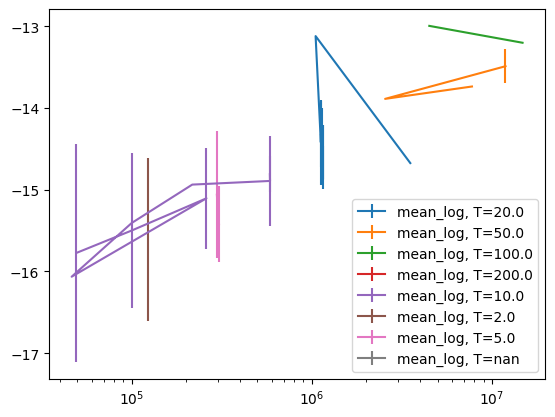

In [68]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

